# Часть 1. Stable Diffusion

In [ ]:
import torch
import tqdm
from diffusers import DiffusionPipeline
import os
from conf import hf_key

os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
#torch.cuda.empty_cache()
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

checkpoint_path = "D:/huggingface/checkpoint/absolutereality_v181.safetensors"


pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", 
                                         dtype=torch.bfloat16, 
                                         cache_dir="D:/huggingface",
                                         token=hf_key, #токен получаем на сайте улыбающегося лица
                                         device_map="cuda")

#Хотел загрузить чекпоинт для улучшения качества, но не понял как
#Вот тут гайд как можно сделать в lora, но чекпоинт не из лоры (вроде как):https://huggingface.co/docs/diffusers/v0.18.2/en/using-diffusers/other-formats
#pipe.unet.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
#pipe.to("cuda")
#чисто в интернетике нашел промт
prompt = "craft a  studio portrait of a hot supermodel Slavic woman, (pale:1.6), 28 year old (long hair:1.2), bushy eyebrows, angular jaw, (very light blue gray:2 eyes), with an intense gaze, highlighting the intricate details of their facial features and expressions. The environment should be minimalistic, with soft, diffused lighting that enhances the details of their face"
negative_prompt = "canvas frame, cartoon, 3D, disfigured, bad art, deformed, extra limbs, close up, black & white, blurry, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, ugly, bad anatomy, bad proportions, cloned face, out of frame, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, Photoshop, video game, tiling, poorly drawn feet, body out of frame, cross-eye, 3D render, nsfw, badhands, ((t-shirt graphics)), shall, bride, hood, (open mouth:1.2)"

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,  # Количество шагов
    guidance_scale=7.5,       # Guidance scale
    height=512,  # Размер
    width=512
).images[0]

image.save("generated_image_3.png")

Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusion3Pipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['lighting that enhances the details of their face']
Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['lighting that enhances the details of their face']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, photoshop, video game, tiling, poorly drawn feet, body out of frame, cross - eye, 3 d rende

  0%|          | 0/50 [00:00<?, ?it/s]

In [2]:
prompt = "craft a  studio portrait of a hot supermodel Mexican woman, (pale:1.6), 28 year old (long hair:1.2), bushy eyebrows, angular jaw, (very light blue gray:2 eyes), with an intense gaze, highlighting the intricate details of their facial features and expressions. The environment should be minimalistic, with soft, diffused lighting that enhances the details of their face"
negative_prompt = '(worst quality:2), (low quality:2), (normal quality:2), (monochrome), normal quality, lowres, watermark'

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=5,  # Количество шагов
    guidance_scale=7.5,       # Guidance scale
    height=512,  # Уменьшите разрешение для теста (по умолчанию 1024x1024 много жрёт)
    width=512
).images[0]

image.save("generated_image_2.png")

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['that enhances the details of their face']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['that enhances the details of their face']


  0%|          | 0/5 [00:00<?, ?it/s]

# Часть 2. DDPM

Выполнял по гайду https://www.kaggle.com/code/vikramsandu/ddpm-from-scratch-in-pytorch/notebook#Image-Generation/Inference

Если было нельзя, переделаю

In [29]:
# Импорт библиотек
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from torch.utils.data.dataset import Dataset

В прямом процессе мы постепенно «размываем» изображение, добавляя к нему всё больше шума на каждом шаге. На первых шагах изображение ещё различимо, но к последним шагам оно становится полностью случайным. Этот процесс не требует обучения — он полностью детерминирован и задаётся расписанием дисперсий 𝛽𝑡

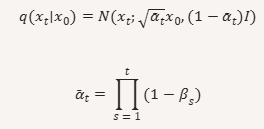

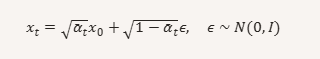

In [ ]:
class DiffusionForwardProcess:
    def __init__(self, num_time_steps = 1000, beta_start = 1e-4, beta_end = 0.02):
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)#линейное пространство
        self.alphas = 1 - self.betas #1- бетта
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)#кумулятивные произведения
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)#корень для добавления шума
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)#корень для масштабирования шума
        
    def add_noise(self, original, noise, t): #добавляем шум к оригинальным изображением на выбранных шагах
        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]
        
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]
        
        return (sqrt_alpha_bar_t * original)+(sqrt_one_minus_alpha_bar_t * noise)#нижняя формула

In [ ]:
#проверяем что все работает
img_size = 28 #размер изображения MNIST
T = 1000 #количество шагов диффузии

original = torch.randn(4, 1, img_size, img_size)
noise = torch.randn(4, 1, img_size, img_size)
t_steps = torch.randint(0, T, (4,)) 

dfp = DiffusionForwardProcess()
out = dfp.add_noise(original, noise, t_steps)
out.shape

torch.Size([4, 1, 28, 28])

Обратный процесс — это попытка по зашумлённому изображению и номеру шага восстановить исходное изображение. На каждом шаге сеть предсказывает, какой шум был добавлен, и вычитает его, постепенно двигаясь от хаоса к структуре. Важно, что на каждом шаге сеть видит не только само изображение, но и номер шага (time embedding), что позволяет ей учитывать степень зашумления

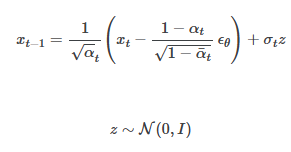

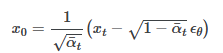

In [ ]:
class DiffusionReverseProcess:
    def __init__(self, num_time_steps = 1000, beta_start = 1e-4, beta_end = 0.02): 
        self.b = torch.linspace(beta_start, beta_end, num_time_steps)
        self.a = 1 - self.b
        self.a_bar = torch.cumprod(self.a, dim=0)
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        x0 = xt - (torch.sqrt(1 - self.a_bar.to(xt.device)[t]) * noise_pred)
        x0 = x0/torch.sqrt(self.a_bar.to(xt.device)[t])
        x0 = torch.clamp(x0, -1., 1.) 
        
        mean = (xt - ((1 - self.a.to(xt.device)[t]) * noise_pred)/(torch.sqrt(1 - self.a_bar.to(xt.device)[t])))
        mean = mean/(torch.sqrt(self.a.to(xt.device)[t]))
        
        if t == 0: #на нулевом, не добавляет дополнительный шум
            return mean, x0
        
        else:
            variance =  (1 - self.a_bar.to(xt.device)[t-1])/(1 - self.a_bar.to(xt.device)[t])
            variance = variance * self.b.to(xt.device)[t]
            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

In [ ]:
#проверяем что все работает
original = torch.randn(1, 1, img_size, img_size)
noise_pred = torch.randn(1, 1, img_size, img_size)
t = torch.randint(0, T, (1,)) 

drp = DiffusionReverseProcess()
out, x0 = drp.sample_prev_timestep(original, noise_pred, t)
out.shape

torch.Size([1, 1, 28, 28])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#создания позиционных эмбеддингов
#нужно, чтобы UNet учитывало информацию о текущем шаге
def get_timestep_embedding(t, dim):
    half_dim = dim // 2
    freq = torch.exp(-math.log(10000) * torch.arange(half_dim) / half_dim)
    angles = t[:, None].float() * freq[None, :]
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
    return emb

t_embeddings = get_timestep_embedding(torch.arange(T), dim=64).to(device) 


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_groups=8):
        super().__init__()
        num_groups = min(num_groups, in_ch)
        self.gn1 = nn.GroupNorm(num_groups, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1) # (B, out_ch, H, W)
        self.act = nn.SiLU() 
        self.linear = nn.Linear(64, out_ch) # (B, out_ch)
        self.gn2 = nn.GroupNorm(num_groups, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1) # (B, out_ch, H, W)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity() # (B, out_ch, H, W)

    def forward(self, x, t_embed):
        t_embed = self.linear(t_embed).unsqueeze(-1).unsqueeze(-1) # (B, out_ch, 1, 1)
        embeddings = self.act(self.conv1(self.gn1(x))) + t_embed # (B, out_ch, H, W)
        return self.act(self.skip(x) + self.conv2(self.gn2(embeddings)))

class ResidualBlockSeq(nn.Module):
    def __init__(self, blocks):
        super().__init__()
        self.blocks = nn.ModuleList(blocks)
    
    def forward(self, x, t_embed):
        for block in self.blocks:
            x = block(x, t_embed)
        return x

class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        B, C, H, W = x.shape
        q = self.q(x).view(B, C, H*W).permute(0, 2, 1)  # B x N x C
        k = self.k(x).view(B, C, H*W)                     # B x C x N
        v = self.v(x).view(B, C, H*W).permute(0, 2, 1)  # B x N x C

        attn = torch.softmax(q @ k / (C**0.5), dim=-1)  # B x N x N
        out = attn @ v                                 # B x N x C
        out = out.permute(0, 2, 1).view(B, C, H, W)
        return x + self.gamma * out

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        #Embedding
        self.embed = nn.Sequential(
            nn.Linear(64, 128),
            nn.SiLU(),
            nn.Linear(128, 64)
        )

        #Encoder
        self.enc1 = ResidualBlockSeq([
            ResidualBlock(1, 16),
            ResidualBlock(16, 16)
        ])
        self.down1 = nn.Conv2d(16, 32, 4, stride=2, padding=1)  # 28 → 14

        self.enc2 = ResidualBlockSeq([
            ResidualBlock(32, 32),
            ResidualBlock(32, 32)
        ])
        self.down2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 14 → 7
        self.attn14 = SelfAttention(32)

        #Bottleneck
        self.bottleneck = ResidualBlockSeq([
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        ])

        #Decoder
        self.up2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)  # 7 → 14
        self.dec2 = ResidualBlockSeq([
            ResidualBlock(64, 32),
            ResidualBlock(32, 32)
        ])

        self.up1 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)  # 14 → 28
        self.dec1 = ResidualBlockSeq([
            ResidualBlock(32, 16),
            ResidualBlock(16, 16)
        ])

        self.final = nn.Conv2d(16, 1, 1) # -> (B, 1, 28, 28)
    
    def forward(self, x, t):
        # Embed timestep
        t_embed = t_embeddings[t]
        if t_embed.ndim == 1: 
            t_embed = t_embed.unsqueeze(0) 
        
        t_embed = self.embed(t_embed)

        # Encoder
        x1 = self.enc1(x, t_embed) # -> (B, 16, 28, 28)
        x2 = self.enc2(self.down1(x1), t_embed) # -> (B, 32, 14, 14)
        x2 = self.attn14(x2)  

        # Bottleneck
        x3 = self.bottleneck(self.down2(x2), t_embed) # -> (B, 64, 7, 7)

        # Decoder 
        x4 = self.up2(x3) # -> (B, 32, 14, 14)
        x4 = torch.cat([x4, x2], dim=1) # -> (B, 64, 14, 14)
        x4 = self.dec2(x4, t_embed) # -> (B, 32, 14, 14)

        x5 = self.up1(x4) # -> (B, 16, 28, 28)
        x5 = torch.cat([x5, x1], dim=1) # -> (B, 32, 28, 28)
        x5 = self.dec1(x5, t_embed) # -> (B, 16, 28, 28)

        output = self.final(x5) # -> (B, 1, 28, 28)
        return output

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # [0,1] -> [-1,1]
])

mnist_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_dl = torch.utils.data.DataLoader(mnist_ds, batch_size=64, shuffle=True)

In [ ]:
model = UNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

dfp = DiffusionForwardProcess()

best_eval_loss = float('inf')

for epoch in range(10):
    losses = []
    model.train()
    
    for batch in tqdm(mnist_dl):
        imgs, labels = batch 
        imgs = imgs.to(device)
        
        noise = torch.randn_like(imgs).to(device)#генерируем шум, того же размера, что и изображение на устройстве
        t = torch.randint(0, T, (imgs.shape[0],)).to(device)#случайные timesteps для батча на устройстве
        
        noisy_imgs = dfp.add_noise(imgs, noise, t)# добавить шум к изображениям на выбранных timesteps
        
        optimizer.zero_grad()# обнулить градиенты оптимизатора
        
        noise_pred = model(noisy_imgs, t)#предсказание
        
        loss = criterion(noise_pred, noise)#потеря
        losses.append(loss.item())
        
        loss.backward()#обратное распространений
        optimizer.step()#обновить параметры модели
    
    mean_epoch_loss = np.mean(losses)
    
    print('Epoch:{} | Loss : {:.4f}'.format(
        epoch + 1,
        mean_epoch_loss,
    ))

100%|██████████| 938/938 [00:16<00:00, 56.73it/s]


Epoch:1 | Loss : 0.1056


100%|██████████| 938/938 [00:16<00:00, 56.74it/s]


Epoch:2 | Loss : 0.0413


100%|██████████| 938/938 [00:16<00:00, 56.83it/s]


Epoch:3 | Loss : 0.0349


100%|██████████| 938/938 [00:16<00:00, 57.67it/s]


Epoch:4 | Loss : 0.0320


100%|██████████| 938/938 [00:16<00:00, 56.79it/s]


Epoch:5 | Loss : 0.0305


100%|██████████| 938/938 [00:16<00:00, 56.57it/s]


Epoch:6 | Loss : 0.0289


100%|██████████| 938/938 [00:16<00:00, 57.27it/s]


Epoch:7 | Loss : 0.0282


100%|██████████| 938/938 [00:16<00:00, 57.07it/s]


Epoch:8 | Loss : 0.0273


100%|██████████| 938/938 [00:18<00:00, 49.97it/s]


Epoch:9 | Loss : 0.0266


100%|██████████| 938/938 [00:18<00:00, 49.67it/s]

Epoch:10 | Loss : 0.0263
Done training.....


In [39]:
def generate(visualize=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Установить устройство для генерации
    drp = DiffusionReverseProcess()  # Инициализировать процесс обратной диффузии
    
    xt = torch.randn(1, 1, img_size, img_size).to(device)  # Сгенерировать начальный случайный шум для генерации
    intermediates = []  # Список для промежуточных изображений
    
    if visualize:
        intermediates.append(xt.clone().cpu())  # Добавить начальное шумовое изображение
    
    with torch.no_grad():  # Отключить градиенты для inference
        for t in reversed(range(T)):  # Цикл по timestep в обратном порядке от T-1 до 0
            noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))  # Предсказать шум моделью на текущем timestep
            xt, x0 = drp.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))  # Вычислить предыдущий timestep
            if visualize and t % 100 == 0:  # Сохранять каждые 100 шагов
                intermediates.append(xt.clone().cpu())  # Добавить промежуточное изображение

    xt = torch.clamp(xt, -1., 1.).detach().cpu()  # Ограничить значения в [-1,1], отсоединить и переместить на CPU
    xt = (xt + 1) / 2  # Нормализовать в [0,1]
    
    if visualize:
        return xt, intermediates  # Вернуть финальное изображение и intermediates
    return xt

100%|██████████| 64/64 [05:43<00:00,  5.36s/it]


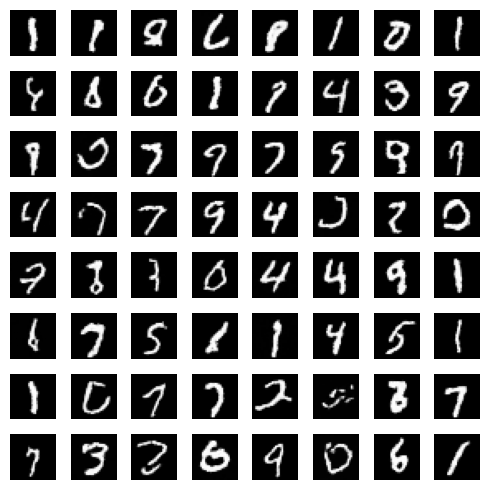

In [40]:
generated_imgs = []
for i in tqdm(range(64)):
    xt = generate()
    xt = 255 * xt[0][0].numpy()
    generated_imgs.append(xt.astype(np.uint8).flatten())

fig, axes = plt.subplots(8, 8, figsize=(5, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(np.reshape(generated_imgs[i], (28, 28)), cmap='gray')  
    ax.axis('off') 

plt.tight_layout() 
plt.show()

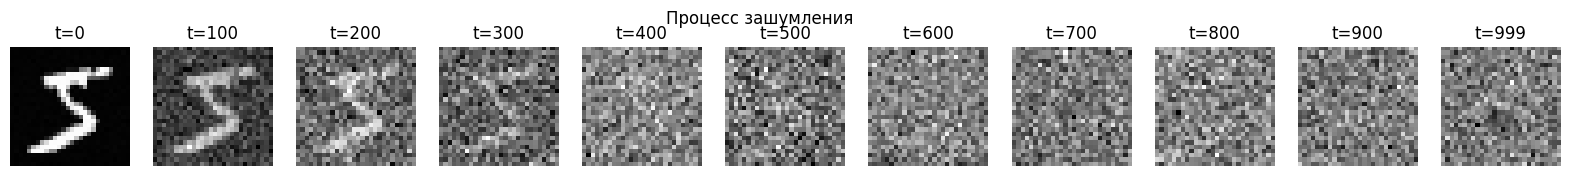

In [ ]:
def visualize_noising():
    img, _ = mnist_ds[0]  # Взять первое изображение из датасета
    img = img.unsqueeze(0).to(device)  # Добавить batch dimension и переместить на устройство
    
    timesteps = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]  # Выбрать timesteps для визуализации
    noisy_images = []
    
    for t_val in timesteps:
        noise = torch.randn_like(img).to(device)  # Сгенерировать шум
        t = torch.tensor([t_val]).to(device)  # Создать тензор timestep
        noisy_img = dfp.add_noise(img, noise, t)  # Добавить шум на текущем timestep
        noisy_images.append(noisy_img.squeeze(0).cpu().numpy())  # Сохранить изображение как numpy array
    

    fig, axes = plt.subplots(1, len(timesteps), figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(noisy_images[i][0], cmap='gray')  # Отобразить в grayscale
        ax.set_title(f't={timesteps[i]}')  # Установить заголовок с timestep
        ax.axis('off')  # Отключить оси
    plt.suptitle('Процесс зашумления')  # Установить общий заголовок
    plt.show()  # Показать plot

visualize_noising()

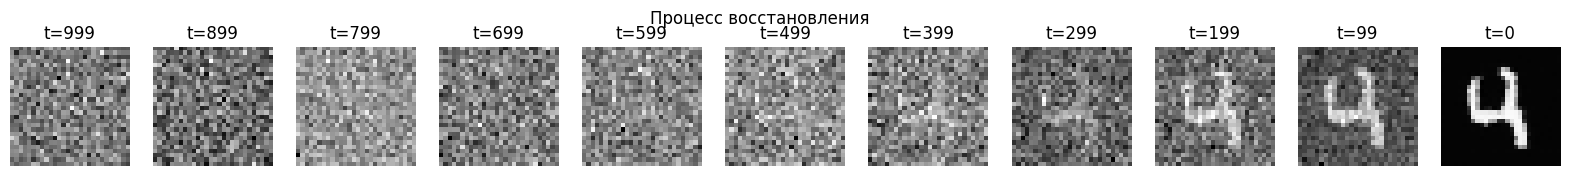

In [ ]:
def visualize_recovery():
    _, intermediates = generate(visualize=T)  # Сгенерировать с intermediates
    
    # Нормализовать intermediates в [0,1]
    intermediates = [(img.squeeze(0) + 1) / 2 for img in intermediates]
    
    timesteps = list(range(T-1, -1, -100)) + [0]  # Timesteps в обратном порядке каждые 100
    if len(timesteps) > len(intermediates):
        timesteps = timesteps[:len(intermediates)]
    

    fig, axes = plt.subplots(1, len(intermediates), figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(intermediates[i][0].numpy(), cmap='gray')  # Отобразить в grayscale
        ax.set_title(f't={timesteps[i]}')  # Установить заголовок с timestep
        ax.axis('off')  # Отключить оси
    plt.suptitle('Процесс восстановления')  # Установить общий заголовок
    plt.show()  # Показать plot

visualize_recovery()